# Goal
Explore neural network regression of pixel sum regression when dealing with noisy data. Formulate expectations of predictions (after training) with respect to the noise in the input.

In [2]:
import keras
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.keras.backend.set_floatx('float64')

# Regression of pixel sum
A network of one neuron fully connected to $N=n\times n$ pixels of an input image is easily capable to learn regression of the sum of all pixel values. This is accomplished when the bias is 0 and all weights are 1. Only the chosen floating-point accuracy of the network parameters cause some error:

32/32 [==============================] - 0s 680us/step
Rel. error:  7.918841596567897e-08
Comparison of expl. values:  27.23093 27.23093241781294


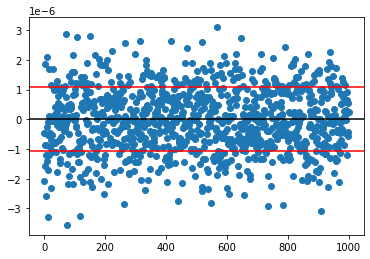

In [4]:
W = 7 # side length (width) of images
N = 1000 # no. samples

data = np.random.rand(N,W,W)
truth = np.sum(data, axis=(1,2)) # sum of all pixels in a image for all samples
truth_range = np.max(truth) - np.min(truth)

model = keras.Sequential([keras.Input(shape=(W,W)), # Shallow network
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)]) # no bias

model.get_weights()
model.set_weights([np.ones((W*W,1))]) # Set all weights to 1.

pred = model.predict(data).flatten() # predict pixel sum
res = pred - truth # residuals
std = np.std(res)

plt.plot(res, 'o');
plt.axhline(0, c='k');
plt.axhline(std, c='red');
plt.axhline(-std, c='red');

print('Rel. error: ', std / truth_range)
print('Comparison of expl. values: ', pred[0], truth[0]) # error only by "rounding", i.e. cutoff. If we use tf.keras.backend.set_floatx('float64') we can decrease this error.

Let's train the network and see how it performs:

32/32 [==============================] - 0s 500us/step
Rel. error:  1.220189557526595e-07


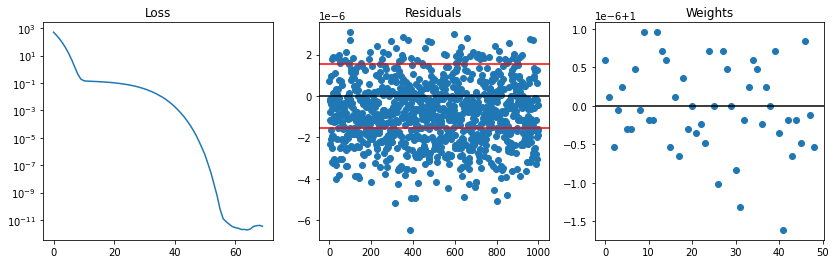

In [3]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(data, truth, epochs=70, verbose=False, batch_size=4)

pred = model.predict(data).flatten()
res = pred - truth
std = np.std(res)
print("Rel. error: ", std / truth_range);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_yscale('log');
ax[0].set_title('Loss');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

After only a couple of epochs our training converges (note the loss plot is in log scale). We see that the network correctly finds weights in the neighborhood of $1$.<br>

**Note:** After epoch 80 something weird happens when we train with M

# Regression of noisy pixel sum
Now, let's add some noise to each pixel value.

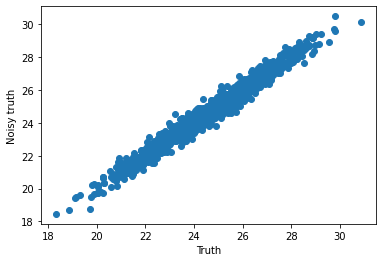

In [4]:
std = 0.05
noisy_data = data + np.random.normal(0,std,size=data.shape)
noisy_truth = np.sum(noisy_data, axis=(1,2)) 
plt.plot(truth, noisy_truth, 'o');
plt.xlabel('Truth');
plt.ylabel('Noisy truth');

In this case, let the standard deviation of the $i$-th pixel value be $\sigma_i$ for $N=n\times n$ total pixel values in an image. Then for the sum of pixel values we have $\sigma_{tot}=\sqrt{\sum_{i=1}^N{\sigma_i^2}}$. Here we set $\sigma=0.05, N=49$, thus $\sigma_{tot}=\sqrt{49\times 0.05^2}=0.35$. Next, we train our network using the noisy data and the (not noisy) truth. Afterwards, we are interested in the standard deviation of the noise in the predictions. This is simply the standard deviation of the residuals.

32/32 [==============================] - 0s 565us/step
Standard deviation of residuals: 0.3623756348742376


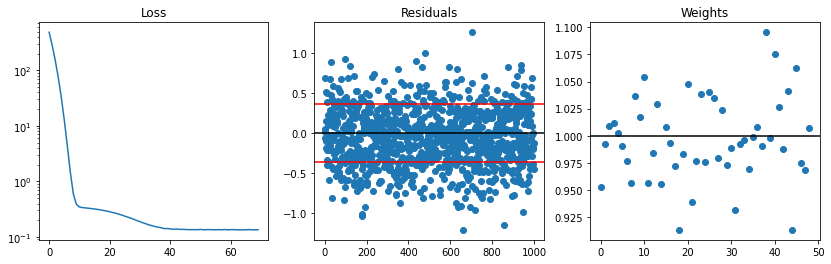

In [5]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(noisy_data, truth, epochs=70, verbose=False, batch_size=4)

pred = model.predict(noisy_data).flatten()
res = pred - truth
std = np.std(res)
print("Standard deviation of residuals:", std);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[0].set_yscale('log');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

The error in our predictions is very close to the noise in the data. If we repeat this training for increasing noise, we can observe that the error in the predictions scales linearly with the noise in the data. This is not very surprising in hindsight but still a point worse emphasizing:
* (Random, "structureless") noise in the input will also appear in the predictions.

# Regression of increasingly noisy pixel sums
Let's see how the network performs for data where the std of the noise scales with its pixel sum.

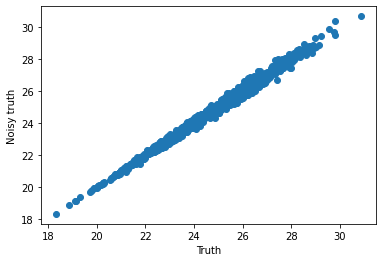

In [6]:
std = (truth-np.min(truth)) / (np.max(truth) - np.min(truth)) * 0.05
noisy_data = data + np.random.normal(0,std[:,None,None], data.shape)
noisy_truth = np.sum(noisy_data, axis=(1,2)) 
plt.plot(truth, noisy_truth, 'o');
plt.xlabel('Truth');
plt.ylabel('Noisy truth');

This is a similar situation which we have when we encode calorimeter data with 4E3M, although here the pixel values are uniformly distributed, while in calorimeters the pixel values have certain distribution (see later). Let's train a network on these data.

32/32 [==============================] - 0s 541us/step
Standard deviation of residuals (predictions): 0.17413746469365388
Standard deviation of residuals (noisy truth): 0.1774657373197544


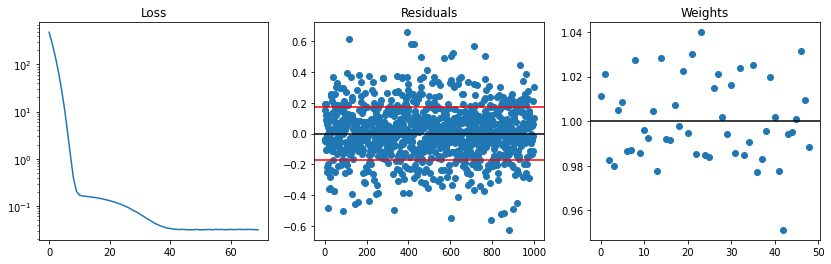

In [8]:
model = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(noisy_data, truth, epochs=70, verbose=False, batch_size=4)

pred = model.predict(noisy_data).flatten()
res = pred - truth
std = np.std(res)
ids = truth.argsort()
print("Standard deviation of residuals (predictions):", std);
print("Standard deviation of residuals (noisy truth):", np.std(noisy_truth[ids] - truth[ids]));

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[0].set_yscale('log');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(model.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

The decrease in noise in the input is again mirrored by the predictions. The reduction of noise is of about a factor of $1.8$, thus not fully 2 (which one would naively expect). Also, we see that the error in the predictions is actually _slightly better_ than naively taking the sum of noisy pixel values. This we can further illustrate by plotting the residuals of both as function of truth:

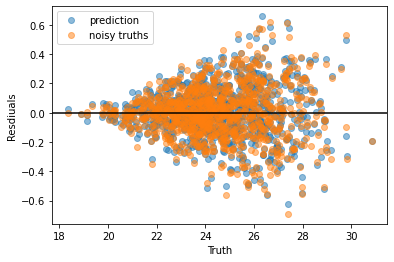

In [9]:
sorted_res = pred[ids] - truth[ids]
plt.plot(truth[truth.argsort()], sorted_res, 'o', alpha=0.5, label='prediction');
plt.plot(truth[ids], noisy_truth[ids] - truth[ids], 'o', alpha=0.5, label='noisy truths');

plt.axhline(0, c='k');
plt.ylabel('Resdiuals');
plt.xlabel('Truth');
plt.legend();

**Result**: For any shallow (or deep) network which maps an input image to a single (fully connected) output neuron we are able to learn a function which regresses the pixel sum of about the same error as the noise in the data. For increasingly noisy data the std of the residuals truth-prediction approximately halves in comparison to "peak" noise over the entire scale. **The main take-away is that the std of the residuals $\hat{y}-y$ and $\tilde{y}-y$ are approximately the same.** (where $y$ is the truth, $\hat{y}$ is the prediction and $\tilde{y}$ is data with (random) noise applied to it.)

# Calorimeter data
Next, we want to consider a specific type of data, namely calorimeter data. Take a look at the notebook `detector_data.ipynb` in this repository to get a better idea of how it looks. We basically generate images of pixel values sampled from a beta-distribution, which we then encode into the 4E3M format which introduces _increasing noise_ in the pixel values:<br>
<table>
    <tr>
        <td><img src="mod2.png" width="400"></td>
        <td><img src="mod1.png" width="400"></td>
    </tr>
</table>

In the calorimeter, the data we get is encoded into 4E3M. If we can train a network to learn the decoding function, we can generate the true (increasingly noisy) distribution for which we know by the above the amount of noise we can expect in the predictions of a trained regression network, namely the same amount that is present in the input. Thus, in the following we show:
1. How to train a network to learn the decoding function, lets call it the "decoder".
2. How to concatenate the "decoder" with the "regressor" (from above) in order to obtain predictions of pixel sums from **noisy, encoded** pixel values.
3. How to train a network to learn decoding and regressing at once.

# Mapping between representations
Our function of interest is a non-linear map which maps values of an exponential range into a linear one (0..127).

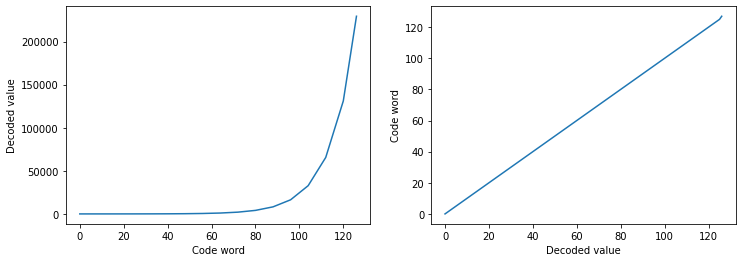

In [10]:
from bitstring import BitArray
from functools import lru_cache

exp_bits = 4
man_bits = 3
max_TCval = (2**man_bits - 1) * 2**(2**exp_bits - 1)
max_TCcode = 2**(man_bits+exp_bits) - 1

@np.vectorize
@lru_cache(128)
def decode(code):
    code = int(code)
    assert(code.bit_length() <= man_bits+exp_bits)
    assert(code >= 0)
    
    bits = BitArray(uint=code, length=man_bits+exp_bits)
    ebits = bits[:exp_bits]
    mbits = bits[exp_bits:]
    
    if ebits.uint == 0:
        return mbits.uint
    else:
        return (BitArray('0b1') + mbits).uint << (ebits.uint - 1)
    
@np.vectorize
@lru_cache(128)
def encode(val):
    assert(val >= 0)
    val = np.int32(val)
    bit_len = val.item().bit_length()
    if bit_len <= man_bits:
        return val # special case: return mantissa if value in this range
    if val >= max_TCval:
        return max_TCcode # clip overflow
    
    exp = bit_len - man_bits
    man = val >> exp - 1
    
    ebits = BitArray(uint=exp, length=exp_bits)
    mbits = BitArray(uint=man, length=man.item().bit_length())[1:]
    
    return (ebits+mbits).uint

r = np.array(range(max_TCcode))

fig,ax = plt.subplots(1, 2, figsize=(12,4))

decoded_r = decode(r)
ax[0].plot(decoded_r)
ax[0].set_xlabel('Code word')
ax[0].set_ylabel('Decoded value');

ax[1].plot(encode(decoded_r));
ax[1].set_xlabel('Decoded value')
ax[1].set_ylabel('Code word');

We see the map is invertible, i.e. bijective. Thus, in principle we should be able to find such a map. Though, as the map is non-linear, we need to use some non-linearity in our network and some more depth. Let's first create some data which is _similarly distributed_ as the real detector data. (More info can be found in the `detector_data` notebook).

In [14]:
a,b = 0.02,0.9
N = 10_000
W = 7

r = np.random.beta(a,b,size=(N,W,W))
adcs = (r * max_TCval).astype(int)

codes = encode(adcs)
decodes = decode(codes)

code_sum = np.sum(codes, axis=(1,2))
adc_sum = np.sum(adcs, axis=(1,2))
decode_sum = np.sum(decodes, axis=(1,2))

code_range = np.max(codes) - np.min(codes)
decode_range = np.max(decodes) - np.min(decodes)

codes_normed = codes / code_range
decodes_normed = decodes / decode_range

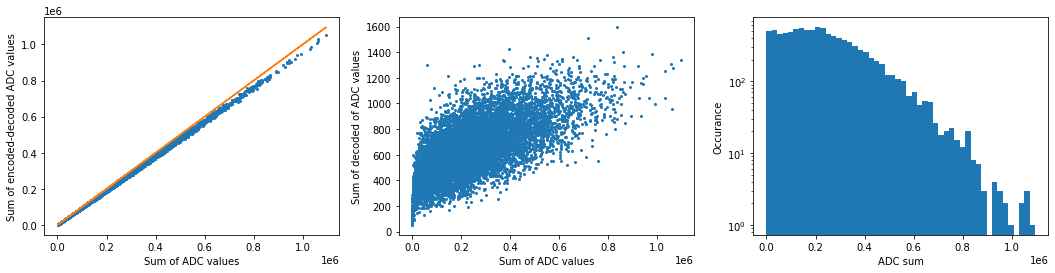

In [53]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].plot(adc_sum, decode_sum, 'o', markersize=2);
ax[0].plot(adc_sum, adc_sum);
ax[0].set_xlabel('Sum of ADC values');
ax[0].set_ylabel('Sum of encoded-decoded ADC values');

ax[1].plot(adc_sum, code_sum, 'o', markersize=2);
ax[1].set_xlabel('Sum of ADC values');
ax[1].set_ylabel('Sum of decoded of ADC values');

ax[2].hist(adc_sum, bins=50);
ax[2].set_xlabel('ADC sum');
ax[2].set_ylabel('Occurance');
ax[2].set_yscale('log');

We see that the generated data is strictly **below** the linear line. This is expected, see `detector_data.ipynb` and a sign that we're doing the right thing. Note that our occurance distribution looks a bit difference than the actual data. I chose these parameters as they gate the best left and middle plots. For the following it matters more that these data are in accordance to the real calo data. Next, lets create a (deep, non-linear) network to learn the decoding.

**Note:** Before we start training we need to rescale the codes and ADCs, s.t. our network parameters can quickly converge.

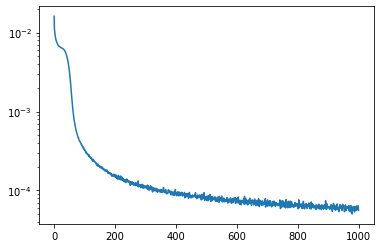

In [17]:
decoder = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(256, activation='sigmoid'),
                          keras.layers.Dense(128, activation='sigmoid'),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(49, activation='linear'),
                          keras.layers.Reshape((7,7))
                         ])


decoder.compile(loss='mse', optimizer='adam')
hist = decoder.fit(codes_normed, decodes_normed, epochs=1000, verbose=False, batch_size=32)#, callbacks=[hist])
plt.plot(hist.history['loss'])
plt.yscale('log')

Let's take a look how the predictions compare to the true ADC sums.

313/313 [==============================] - 0s 676us/step
rel. err:  0.04383884500992596


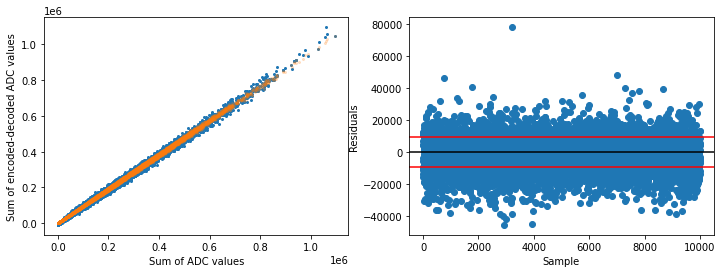

In [18]:
decoder_pred = decoder.predict(codes_normed)
pred_sum = np.sum(decoder_pred * decode_range, axis=(1,2))

res = pred_sum - decode_sum
std = np.std(res)

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(adc_sum, pred_sum, 'o', markersize=2);
ax[0].plot(adc_sum, decode_sum, 'o', markersize=2, alpha=0.2);
ax[0].set_xlabel('Sum of ADC values');
ax[0].set_ylabel('Sum of encoded-decoded ADC values');

ax[1].plot(res, 'o');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[1].set_ylabel('Residuals');
ax[1].set_xlabel('Sample');

print('rel. err: ', std/decode_range)

We see that our network is capable of learning the decoding function with increasing accuracy.

# Concatenate networks
Let's put both networks together.

Before we need do so, we also need to train our regressor on the new calorimeter data. Actually, as we want to use not the perfect, but the noisy data (output data of decoder) as input, we use the decoder predictions from above.

313/313 [==============================] - 0s 518us/step
rel. error: 0.02451190358253845


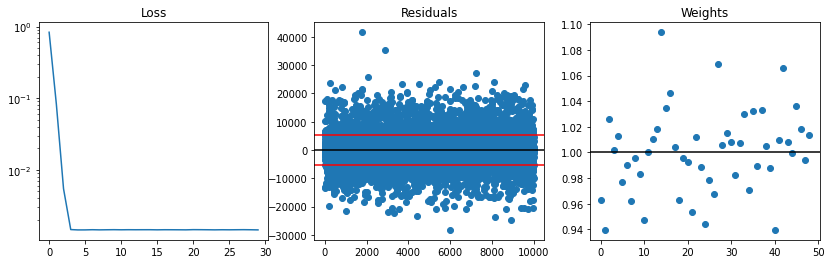

In [19]:
regressor = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1, activation='linear', use_bias=False)])

regressor.compile(loss='mse', optimizer='adam')

normed_decode_sum = decode_sum / decode_range

hist = regressor.fit(decoder_pred, normed_decode_sum, epochs=30, verbose=False, batch_size=4)

pred = regressor.predict(decodes_normed) * decode_range
res = pred.flatten() - decode_sum
std = np.std(res)
print("rel. error:", std/decode_range);

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].plot(hist.history['loss']);
ax[0].set_title('Loss');
ax[0].set_yscale('log');
ax[1].plot(res, 'o');
ax[1].set_title('Residuals');
ax[1].axhline(0, c='k');
ax[1].axhline(std, c='red');
ax[1].axhline(-std, c='red');
ax[2].plot(regressor.get_weights()[0].flatten(), 'o');
ax[2].axhline(1, c='k');
ax[2].set_title('Weights');

Now, concatenate the networks

313/313 [==============================] - 0s 632us/step
rel std error:  0.03752779338359283


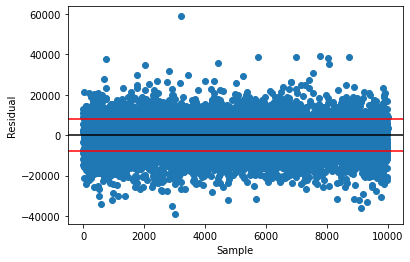

In [20]:
model = keras.Sequential([decoder, regressor])
pred = model.predict(codes_normed) * decode_range

res = pred.flatten() - decode_sum
std = np.std(res)

print('rel std error: ', std/decode_range)
plt.plot(res, 'o');
plt.axhline(std, c='red');
plt.axhline(-std, c='red');
plt.axhline(0, c='k');

plt.xlabel('Sample');
plt.ylabel('Residual');

This looks not too shabby. The relative error is even a bit better than for the naive sum.

# Simultaneous decoding and regression
Let's see how a net trained on decoding and regression at once compares to this.

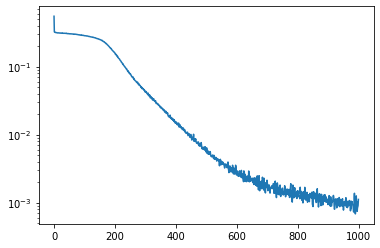

In [21]:
model2 = keras.Sequential([keras.Input(shape=(W,W)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(256, activation='sigmoid'),
                          keras.layers.Dense(128, activation='sigmoid'),
                          keras.layers.Dense(64, activation='sigmoid'),
                          keras.layers.Dense(32, activation='sigmoid'),
                          keras.layers.Dense(1, activation='linear'),
                         ])

model2.compile(loss='mse', optimizer='adam')
hist = model2.fit(codes_normed, normed_decode_sum, epochs=1000, verbose=False, batch_size=32)#, callbacks=[hist])
plt.plot(hist.history['loss'])
plt.yscale('log')

313/313 [==============================] - 0s 661us/step
rel std error:  0.029794941605249425


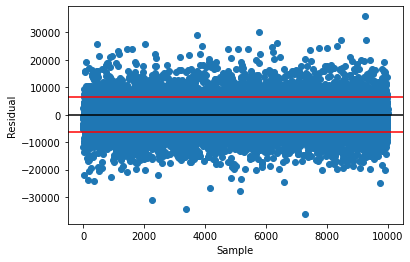

In [22]:
pred = model2.predict(codes_normed) * decode_range

res = pred.flatten() - decode_sum
std = np.std(res)

print('rel std error: ', std/decode_range)
plt.plot(res, 'o');
plt.axhline(std, c='red');
plt.axhline(-std, c='red');
plt.axhline(0, c='k');

plt.xlabel('Sample');
plt.ylabel('Residual');

The combined training can even top that and shows **much better** predictions than both the naive sum and concatenated networks!

# Conclusions
* Pixel sum regression is an easy task which can be learned perfectly (up to given neuron accuracy, i.e. data type accuracy) in a *shallow* network in a short amount of time.
* If we add (random) noise to data the predictions of a regression network exhibit a very similar amount of noise.
* With enough time and training data a network can learn (arbitrary, nonlinear) bijective maps.
* Thus, **we can predict 4E3M encoded calorimeter data at the order (or even better than) the "noise" which the encoding introduced.**
* Lastly, training on decoding and regression together gives the best predictions.